# Computer Vision

## Lab 2


### Imports


In [225]:
# Computation
import cv2
import numpy as np
import skimage
from scipy.cluster.vq import kmeans, whiten

# Plotting
import matplotlib.pyplot as plt

# Typing
import typing as types

In [95]:
image = cv2.imread("./assets/image-83.jpg")
image_rgb = np.array(image[:,:,::-1], dtype=np.float32) / 255

### Section 1


#### 1. Gaussian


In [96]:
def make_Gaussian(sigma: int, shape: tuple[int, int]):
    var = sigma ** 2

    def Gaussian(x, y):
        centred_x = x - shape[0] / 2
        centred_y = y - shape[1] / 2
        return (1/(2 * np.pi * var)) * np.exp(-((centred_x ** 2 + centred_y ** 2) / (2 * var)))

    return np.fromfunction(Gaussian, shape=shape)

##### Apply to image

(-0.5, 599.5, 449.5, -0.5)

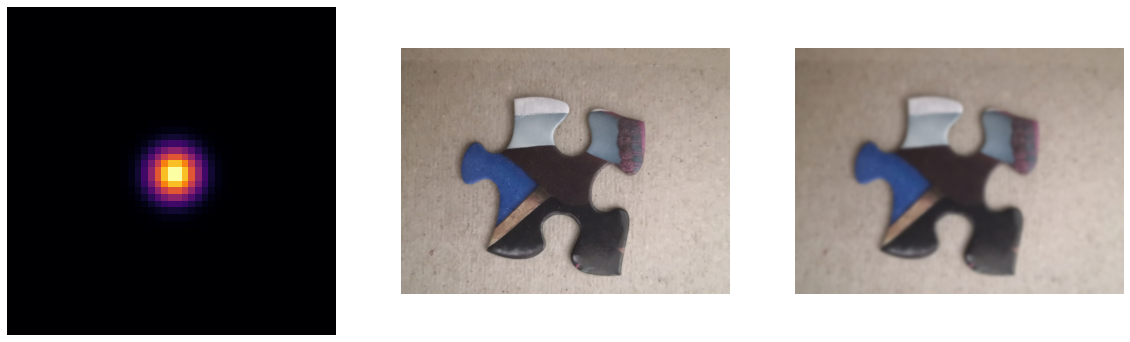

In [117]:
fig = plt.figure(figsize=(20, 8))

kernel_shape = (49, 49)
gaussian = make_Gaussian(sigma=2.5, shape=kernel_shape)
image_gaussian = cv2.filter2D(image_rgb, -1, gaussian)


fig.add_subplot(1, 3, 1)
plt.imshow(gaussian, cmap='inferno')
plt.axis('off')

fig.add_subplot(1, 3, 2)
plt.imshow(image_rgb)
plt.axis('off')

fig.add_subplot(1, 3, 3)
plt.imshow(image_gaussian)
plt.axis('off')

#### 2. Laplacian of Gaussian (LoG)

In [142]:
def make_LoG(sigma: int, shape: tuple[int, int]):
    def LoG(x, y):
        centred_x = x - shape[0] / 2
        centred_y = y - shape[1] / 2
        
        sum_squares = (centred_x ** 2) + (centred_y ** 2)
        exponent = sum_squares / (2 * (sigma ** 2))
        coeff = 1 / (np.pi * (sigma ** 4))
        
        return -coeff * (1 - exponent) * np.exp(-exponent)

    return np.fromfunction(LoG, shape)

##### Apply to image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 599.5, 449.5, -0.5)

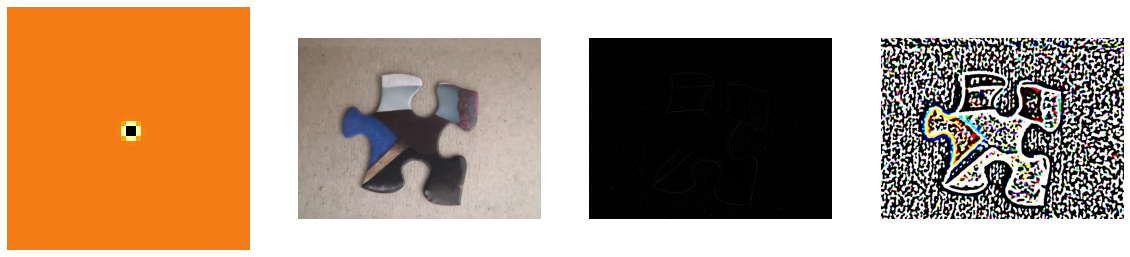

In [254]:
fig = plt.figure(figsize=(20, 8))

sigma = 0.7

kernel_shape = (49, 49)
LoG = make_LoG(sigma=sigma, shape=kernel_shape)
image_LoG = cv2.filter2D(image_rgb, -1, LoG)
lib_LoG = cv2.Laplacian(cv2.GaussianBlur(image_rgb, ksize=(29, 29), sigmaX=sigma), -1, ksize=29)


fig.add_subplot(1, 4, 1)
plt.imshow(LoG, cmap='inferno')
plt.axis('off')

fig.add_subplot(1, 4, 2)
plt.imshow(image_rgb)
plt.axis('off')

fig.add_subplot(1, 4, 3)
plt.imshow(image_LoG)
plt.axis('off')


fig.add_subplot(1, 4, 4)
plt.imshow(lib_LoG)
plt.axis('off')

#### 3. Difference of Gaussians (HoG)

In [100]:
def make_DoG(sigma: int, K: int, shape: tuple[int, int]):
    var = sigma ** 2
    coeff = 1/(2 * np.pi * var)
    
    if not K > 1:
        raise ValueError("K must be greater than 1.")

    def DoG(x, y):
        centred_x = x - shape[0] / 2
        centred_y = y - shape[1] / 2
        exponent = -((centred_x ** 2 + centred_y ** 2) / (2 * var))
        
        return coeff * np.exp(exponent) - coeff * (K ** -2) * np.exp(exponent * (K ** -2))

    return np.fromfunction(DoG, shape=kernel_shape)


##### Apply to image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 599.5, 449.5, -0.5)

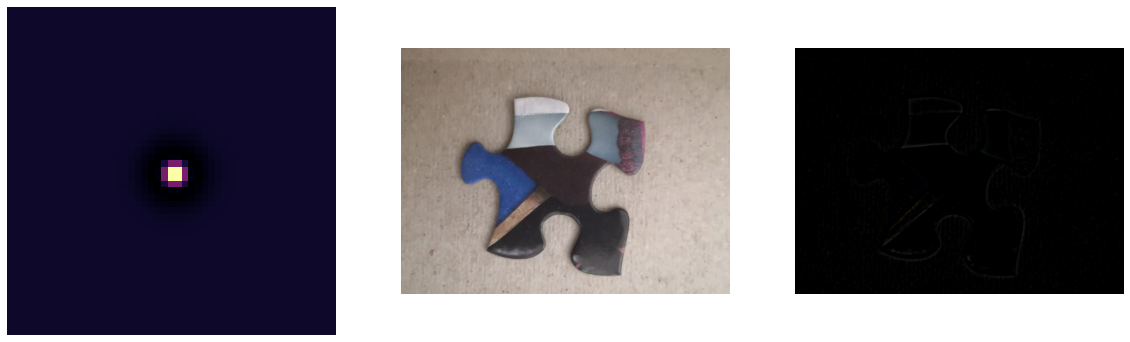

In [106]:
fig = plt.figure(figsize=(20, 8))

kernel_shape = (49, 49)
DoG = make_DoG(sigma=1, K=3, shape=kernel_shape)
image_DoG = cv2.filter2D(image_rgb, -1, DoG)


fig.add_subplot(1, 3, 1)
plt.imshow(DoG, cmap='inferno')
plt.axis('off')

fig.add_subplot(1, 3, 2)
plt.imshow(image_rgb)
plt.axis('off')

fig.add_subplot(1, 3, 3)
plt.imshow(image_DoG)
plt.axis('off')

### Section 2

#### 1. Gaussian Edge & Bar Filters

In [102]:
def make_EdgeBarFilter(theta: int,
                       sigma_x: int,
                       sigma_y: int,
                       shape: tuple[int, int],
                       type: types.Literal['edge', 'bar'] = 'edge'):

    def f(x, sigma):
        return ((2 * np.pi * sigma) ** (-0.5)) * np.exp(-(x ** 2) / (2 * (sigma ** 2)))

    def x_prime(x, y):
        return x * np.cos(theta) - y * np.sin(theta)

    def y_prime(x, y):
        return x * np.sin(theta) + y * np.cos(theta)

    def g(x, y):
        return f(x=x_prime(x, y), sigma=sigma_x) * f(x=y_prime(x, y), sigma=sigma_y)

    def first_dir(x, y):
        centred_x = x - shape[0] / 2
        centred_y = y - shape[1] / 2
        return g(centred_x, centred_y) * ((-y_prime(centred_x, centred_y)) / (sigma_y ** 2))

    def second_dir(x, y):
        centred_x = x - shape[0] / 2
        centred_y = y - shape[1] / 2
        return g(centred_x, centred_y) * (((y_prime(centred_x, centred_y) ** 2) - (sigma_y ** 2)) / (sigma_y ** 4))

    if type == 'bar':
        return np.fromfunction(second_dir, shape=shape)
        
    return np.fromfunction(first_dir, shape=shape)

#### 2. Root Filter Set

In [163]:
sigma_set = np.array([(3, 1), (6, 2), (12, 4)])
theta_set = np.arange(6) * (np.pi/6)
type_set = ['edge', 'bar']
kernel_shape = (49, 49)

rfs = [[make_EdgeBarFilter(theta, sigma[0], sigma[1], kernel_shape, type)
       for theta in theta_set]
       for type in type_set for sigma in sigma_set]
rfs.extend([gaussian, LoG])


##### Visualize RFS

(-0.5, 48.5, 48.5, -0.5)

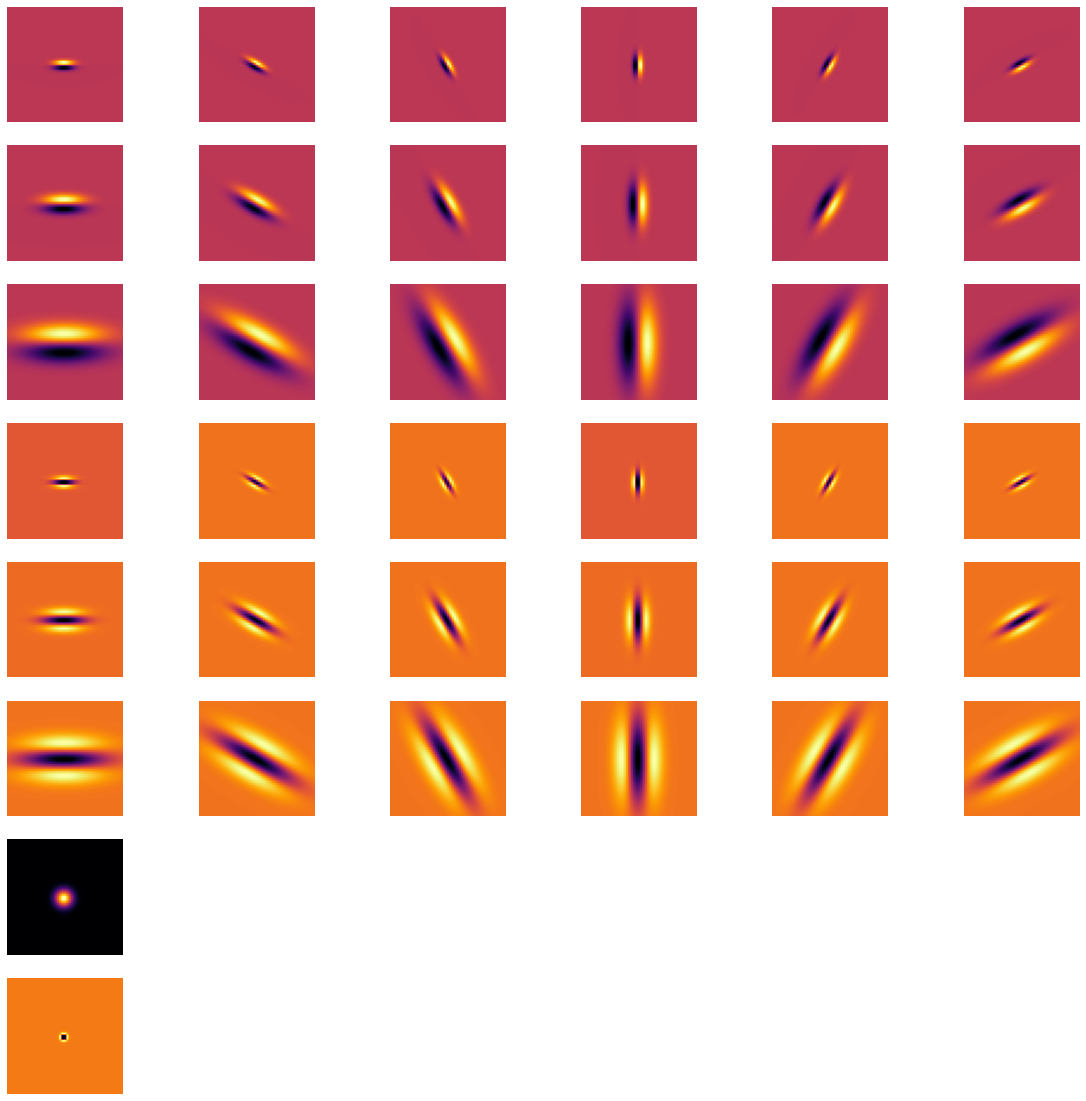

In [165]:
fig = plt.figure(figsize=(20, 20))

for i in range(len(sigma_set) * 2):
    for j in range(len(theta_set)):   
        fig.add_subplot(8, 6, i * len(theta_set) + j  +1)
        plt.imshow(np.flip(np.transpose(rfs[i][j]), axis=1), cmap = 'inferno')
        plt.axis('off')
    

fig.add_subplot(8, 6, 37)
plt.imshow(np.flip(np.transpose(rfs[-2]), axis=1), cmap = 'inferno')
plt.axis('off')

fig.add_subplot(8, 6, 43)
plt.imshow(np.flip(np.transpose(rfs[-1]), axis=1), cmap = 'inferno')
plt.axis('off')


#### Responses

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

(-0.5, 599.5, 449.5, -0.5)

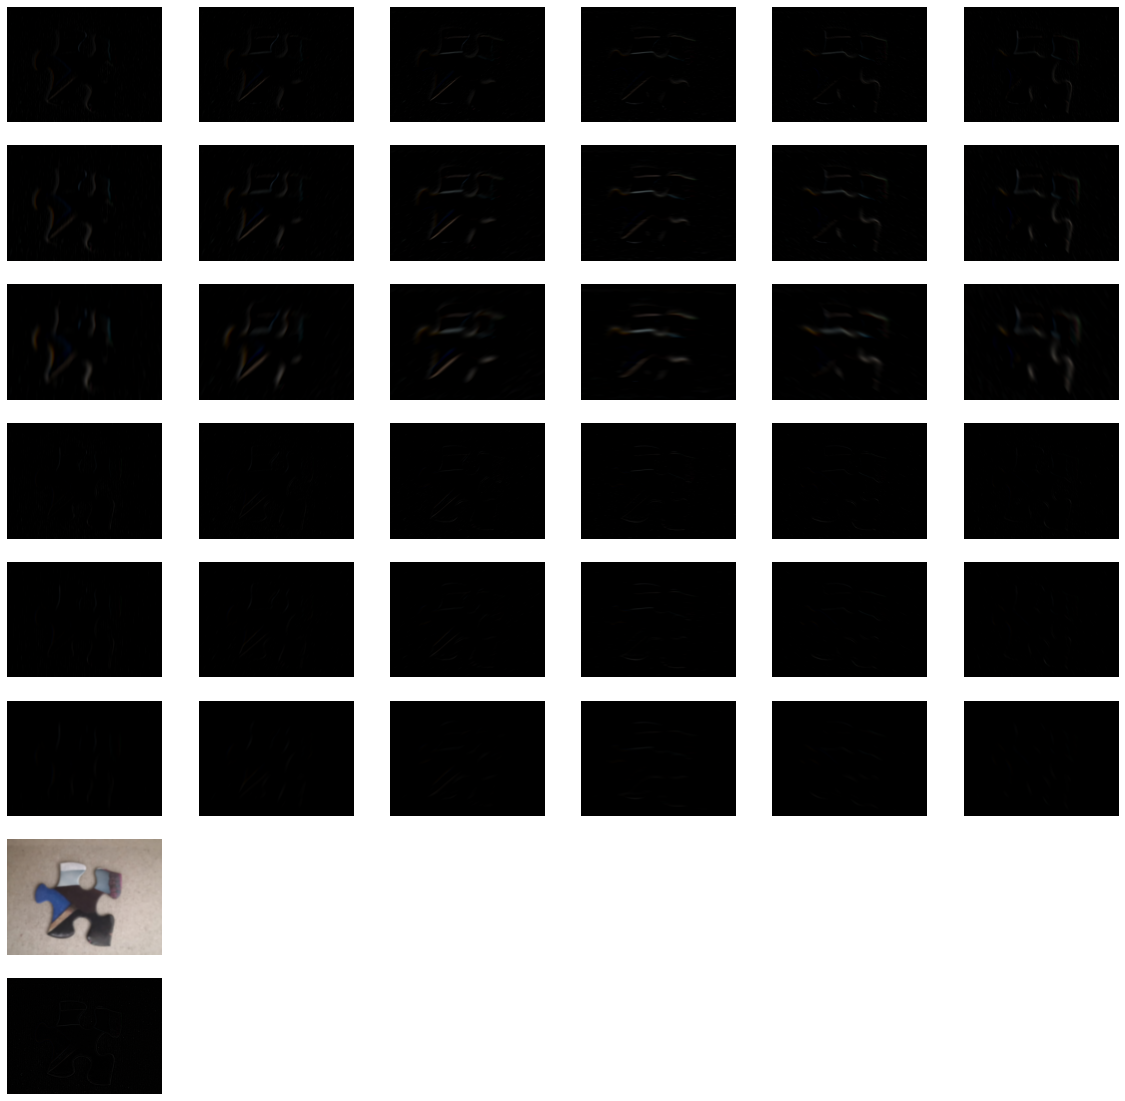

In [168]:
rfs_response = []

fig = plt.figure(figsize=(20, 20))

for i in range(len(sigma_set) * 2):
    row = []
    for j in range(len(theta_set)):  
        resp = cv2.filter2D(image_rgb, -1, rfs[i][j])
        row.append(resp)
        
        fig.add_subplot(8, 6, i * len(theta_set) + j +1)
        plt.imshow(resp, cmap = 'inferno')
        plt.axis('off')
    rfs_response.append(row)


resp = cv2.filter2D(image_rgb, -1, rfs[-2])
rfs_response.append(resp)

fig.add_subplot(8, 6, 37)
plt.imshow(resp, cmap = 'inferno')
plt.axis('off')


resp = cv2.filter2D(image_rgb, -1, rfs[-1])
rfs_response.append(resp)

fig.add_subplot(8, 6, 43)
plt.imshow(resp, cmap = 'inferno')
plt.axis('off')


#### 3. Maximum Response (MR8)

In [177]:
mr8 = []

for i in range(len(theta_set)):
    response_set = rfs_response[i]
    mr8.append(np.max(response_set, axis=0))

mr8.extend(rfs[-2:])

### Section 3

#### 1. Local Binary Patterns

#### 2. Integral Images

#### 3. Haar filter

### Section 4

#### 1. K-means

In [243]:
features = [image_rgb]

features.append(skimage.color.rgb2hsv(image_rgb))

prewitt_vertical = np.asarray([[1, 1, 1], [0, 0, 0], [-1, -1, -1]])
features.append(cv2.filter2D(image_rgb, -1, prewitt_vertical))

prewitt_horizontal = np.asarray([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])
features.append(cv2.filter2D(image_rgb, -1, prewitt_horizontal))

features.append(cv2.Laplacian(image_rgb, -1, ksize=3))

# features.extend(np.array(rfs_response[:-2]).reshape(-1, 450, 600, 3))

# features.extend(rfs_response[-2:])

features = np.array(features).reshape(-1, 450, 600).reshape(-1, 270000)
features.shape

(15, 270000)

In [244]:
whitened = whiten(features)
codebook, distortion = kmeans(whitened, 4)

(-0.5, 599.5, 449.5, -0.5)

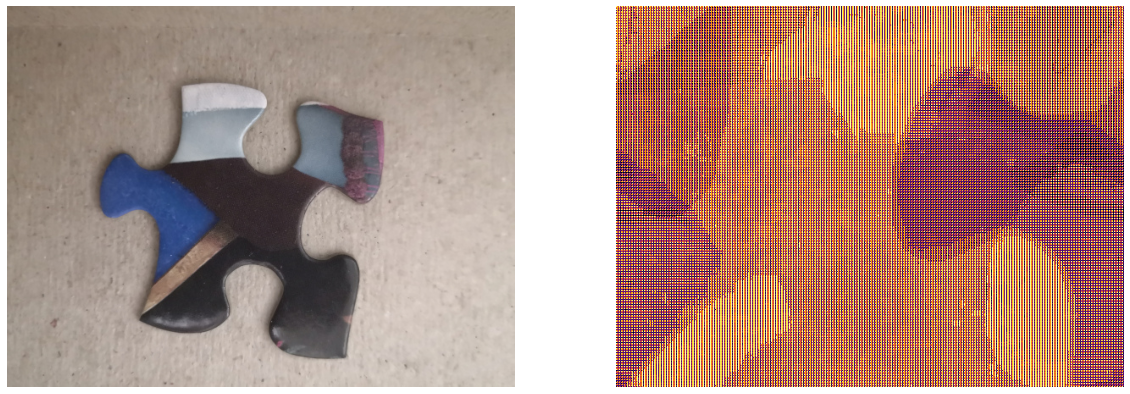

In [247]:
fig = plt.figure(figsize=(20, 8))

texture = np.array(codebook).reshape(-1, 450, 600).argmax(axis=0)

fig.add_subplot(1, 2, 1)
plt.imshow(image_rgb)
plt.axis('off')

fig.add_subplot(1, 2, 2)
plt.imshow(texture, cmap='inferno')
plt.axis('off')

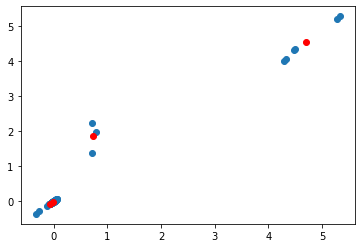

In [233]:
plt.scatter(whitened[:, 0], whitened[:, 1])
plt.scatter(codebook[:, 0], codebook[:, 1], c='r')

#### 2. Centroids

#### 3. Train background classifier

#### 4. Train + MR8 on HSV

#### 5. Other adjustments